кол-во чеков = кол-во походов в магазин

crazy-акция - по всем группам товаров

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn import linear_model, metrics, preprocessing

import azureml.core
from azureml.core import Dataset
from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.core import Experiment, Workspace

import sys
sys.path.append('../scripts/')
from pipeline import StupidModel, run, validate_on_holdout

Perhaps you already have a cluster running?
Hosting the HTTP server on port 44577 instead


In [6]:
# Log In to Azure ML Workspace
interactive_auth = InteractiveLoginAuthentication(tenant_id="76f90eb1-fb9a-4446-9875-4d323d6455ad")

# Initialise workspace
ws = Workspace.from_config(auth=interactive_auth)

# Data import 
aml_dataset = Dataset.get_by_name(ws, 'train_ds', version='latest')
data = aml_dataset.to_pandas_dataframe()
data.set_index('CardHolder', inplace=True)

# Save it to the further opeartions
original_columns = data.columns

# 0. Графика

NameError: name 'stubborn' is not defined

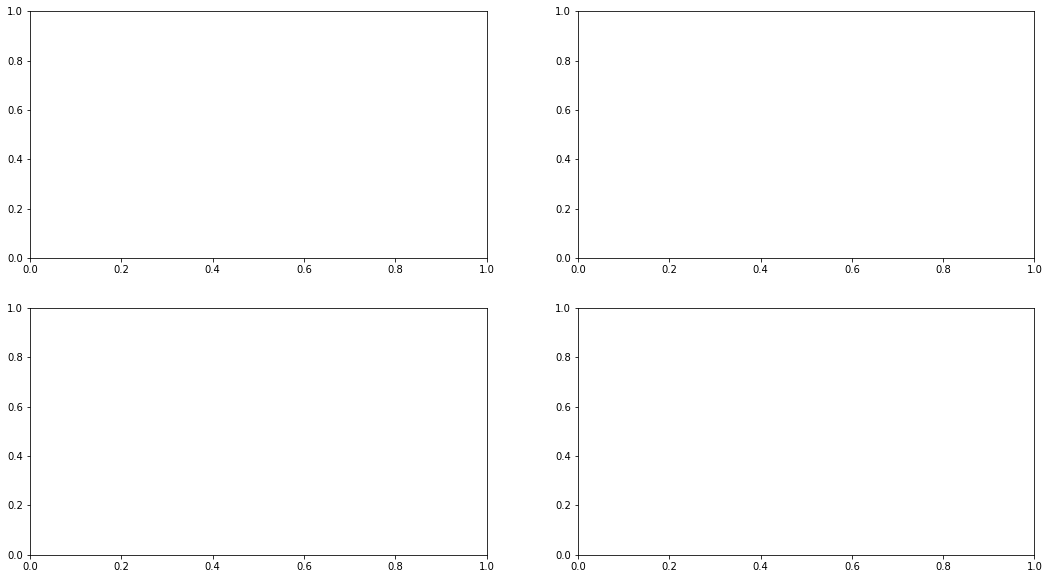

In [7]:
# Let's take random sample in each subgroup with same size
sample_size = 10000

fig, ax = plt.subplots(2, 2, figsize=(18, 10))
sales_sum = ['sale_sum_3m_g{}'.format(i) for i in [24, 26, 32, 33]]

plt.subplot(221)
sample = stubborn.loc[np.random.choice(stubborn.index, sample_size, replace=False)]
sns.scatterplot(sample[sales_sum].sum(axis=1), sample['response_sms'])
plt.title('Участники тестовой группы, которые не пошли на акцию')

plt.subplot(223)
plt.hist(sample['response_sms'])

plt.subplot(222)
sample = active.loc[np.random.choice(active.index, sample_size, replace=False)]
sns.scatterplot(sample[sales_sum].sum(axis=1), sample['response_sms'])
plt.title('Участники тестовой группы, которые пошли на акцию')

plt.subplot(224)
plt.hist(sample['response_sms'])

plt.show()

# 1. Outliers
Первоначальное избавление от выбросов поможет в дальнейшнем грамотнее исправить ошибки в данных

In [8]:
# Any group number is in diaposon from 20 to 79
all_groups = [i for i in range(20, 80)]

# This function returns columns from 'columns' list, which are met in columns of "data"
def get_columns_list(data, columns):
    return data.columns[data.columns.isin(columns)]

Соберем интересующие нас признаки: некоторые уже есть в датасете, некоторые придется собирать.

In [9]:
# Name of a feature : (columns to collect from, method)
# methods : mean, max, min, sum
collect_features = {
    'cheque_count_12m_sum'             : (get_columns_list(data, ['cheque_count_12m_g{}'.format(i) for i in all_groups]), 'sum'),
    'children'                         : (['children'], 'max'),
    'crazy_purchases_cheque_count_12m' : (['crazy_purchases_cheque_count_12m'], 'max'),
    'k_var_disc_share_6m_max'          : (get_columns_list(data, ['k_var_disc_share_6m_g{}'.format(i) for i in all_groups]), 'max'),
    'k_var_sku_price_6m_max'           : (get_columns_list(data, ['k_var_sku_price_6m_g{}'.format(i) for i in all_groups]), 'max'),
    'sale_sum_12m_sum'                  : (get_columns_list(data, ['sale_sum_6m_g{}'.format(i) for i in all_groups]), 'sum'),
}

# Add collections
for key in collect_features.keys():
    method = collect_features[key][1]
    
    if method == 'mean':
        data.loc[:, key] = data[collect_features[key][0]].mean(axis=1)
    elif method == 'sum':
        data.loc[:, key] = data[collect_features[key][0]].sum(axis=1)
    elif method == 'max':
        data.loc[:, key] = data[collect_features[key][0]].max(axis=1)
    elif method == 'min':
        data.loc[:, key] = data[collect_features[key][0]].min(axis=1)
        
# Additional observations
add_features = ['cheques_per_child', 'sales_per_child']
data['cheques_per_child'] = data['cheque_count_12m_sum'] / (data['children'].fillna(0) + 1)
data['sales_per_child'] = data['sale_sum_12m_sum' ] / (data['children'].fillna(0) + 1)

По собранным признакам посмотрим на значения-выбросы, которые опредялетются по разным пропорциям (whis) относительно IQR. Полученные записи разделим на записи из тестовой и контрольной групп и их разделим по участию в акции. Посмотрим на пропорции.

In [ ]:
# Cycle by chosen features
for key in list(collect_features.keys()) + add_features:
    print('Column', key)
    
    # Table format
    dataframe = {'Type' : [i+j for i in ['w/o outliers', 'outliers'] for j in ['_test_0', '_test_1', '_control_0', '_control_1']]}
    for whis in [1, 1.5, 2, 2.5]:
        IQR = data[key].quantile(0.75) - data[key].quantile(0.25)
        
        # Separate data w/o outliers
        sample = data[data[key] <= data[key].quantile(0.75) + IQR * whis]
        
        # Separate groups
        sample_test = sample[sample['group'] == 'test']['response_att'].value_counts()
        sample_control = sample[sample['group'] == 'control']['response_att'].value_counts()
        
        dataframe['whis{}'.format(whis)] = [sample_test[0], sample_test[1], sample_control[0], sample_control[1]]
        
         # Separate data outliers
        sample = data[data[key] > data[key].quantile(0.75) + IQR * whis]
        
        # Separate groups
        sample_test = sample[sample['group'] == 'test']['response_att'].value_counts()
        sample_control = sample[sample['group'] == 'control']['response_att'].value_counts()
        
        dataframe['whis{}'.format(whis)] += [sample_test[0], sample_test[1], sample_control[0], sample_control[1]]
    
    print(pd.DataFrame(dataframe))
    sns.boxplot(data[key])
    plt.show()

In [ ]:
sns.heatmap(data[[key for key in list(collect_features.keys()) + add_features]].corr(), annot=True)
plt.show()

Проверка матрицы корреляции не выявила какой-то особенной связи.

Ни один из проверенных параметров не дал полезного результата: разделяя по выбросам, мы обнаружили, что соотношение людей в тестовой и контрольной группе примерно одно и то же. Отделим выбросы и попытаемся (по whis=1.5) и продолжим поиски. 

In [63]:
# Separation parameter
whis = 1.5

data_map = np.array([])
# Cycle by chosen features
for key in list(collect_features.keys()) + add_features:
    
    # Drop outliers
    IQR = data[key].quantile(0.75) - data[key].quantile(0.25)
    
    if not data_map.size:
        data_map = (data[key] <= data[key].quantile(0.75) + IQR * whis).values
    else:
        data_map = data_map & (data[key] <= data[key].quantile(0.75) + IQR * whis).values
        
data = data[data_map]

# 2. Чистка данных
Решим проблему с NaN. Сначала посмотрим, сколько строк вообще не имеют ошибок

In [46]:
data.isna().any(axis=1).value_counts()

True     532384
False       393
dtype: int64

Таких строк очень мало, поэтому придётся как-то заполнять NaN. Если заполнять средними, то это слишком разрежено, поэтому будем заполнять для каждого индекса по-своему. Индекс - это определенные значения колон из "index_columns". Проблема в том, что и них встречаются NaN значения.

In [47]:
print("Чаще всего у покупателя",
      data['children'].value_counts().sort_values(ascending=False).index[0],
      "детей")

Чаще всего у покупателя 0.0 детей


In [64]:
index_columns = ['gender', 'main_format', 'children']

# Let's fill NaN in "index_columns"
data['group'].replace({'test' : 1, 'control' : 0}, inplace=True)
data['gender'].replace({'М' : 2, 'Ж' : 1, 'Не определен' : 0, None : 0}, inplace=True)
data['children'].replace({None : -1}, inplace=True)

In [65]:
# Calculate percent of records with NaNs
def proportion(series):
    if (series.loc[False] == series.sum()):
        return 0
    return series.loc[True] / series.sum()

dataframe = {'name' : [], 'nans' : []}
for column in data.columns:
    dataframe['name'] += [column]
    dataframe['nans'] += [proportion(data[column].isna().value_counts())]

# Show top 5 by calculated percent
pd.DataFrame(dataframe).sort_values(ascending=False, by='nans')[:5]

,name,nans
120,k_var_sku_price_15d_g49,0.786162
85,k_var_disc_share_15d_g49,0.786042
62,k_var_count_per_cheque_15d_g34,0.736070
119,k_var_sku_price_15d_g34,0.736070
84,k_var_disc_share_15d_g34,0.735981


In [66]:
# Group mean values
group_means = data.groupby(index_columns).mean()
group_means.fillna(group_means.mean(), inplace=True)

for i in group_means.index:
        data.loc[(data['gender'] == i[0]).values &
                 (data['main_format'] == i[1]).values &
                 (data['children'] == i[2]).values] = data.loc[(data['gender'] == i[0]).values &
                     (data['main_format'] == i[1]).values &
                     (data['children'] == i[2]).values].fillna(group_means.loc[i])

Также оптимизируем данные для скорости просчетов

In [67]:
# Attention : takes some time
for column in data.columns:
    if data[column].dtype == 'float64':
        data[column] = data[column].astype('float32')
    if data[column].dtype == 'int64':
        data[column] = data[column].astype('int32')

In [68]:
data = data[original_columns]
data.shape

(532777, 195)

# 3. Поиск класса людей, которым требуется коммуникация
Общий ход действий такой: создадим побольше интерпретируемых признаков и сделаем вектор значений для каждого человека. После этого найдём всем людям из контрольной группы близжайшего по некоторой метрике партнера. Тогда для каждого человека будем знать его поведение как 1 из 4 классов: \
1) идет на акцию, только если с ним коммуницировать \
2) никогда не ходит на акцию \
3) всегда идет на акцию \
4) идет на акцию, только если с ним не коммуницировать

In [69]:
data_copy = data.copy()

In [70]:
data = data.join(pd.get_dummies(data['age']).astype('int32'))

In [71]:
for sum_feature in ['cheque_count_12m_g{}', 'cheque_count_3m_g{}',
                   'cheque_count_6m_g{}', 'sale_count_12m_g{}',
                    'sale_count_6m_g{}', 'sale_count_3m_g{}',
                    'sale_sum_6m_g{}', 'sale_sum_3m_g{}',
                    'sale_sum_12m_g{}'
                   ]:
    data.loc[:, sum_feature[:-4]+'_sum'] = data[get_columns_list(data, [sum_feature.format(i) for i in all_groups])].sum(axis=1)
    
    
for mean_feature in ['k_var_count_per_cheque_1m_g{}',
                     'k_var_count_per_cheque_3m_g{}',
                     'k_var_count_per_cheque_6m_g{}',
                     'k_var_disc_share_1m_g{}',
                     'k_var_disc_share_3m_g{}',
                     'k_var_disc_share_6m_g{}',
                     'k_var_sku_price_3m_g{}',
                     'k_var_sku_price_6m_g{}',
                     'k_var_sku_price_1m_g{}',
                   ]:
    data.loc[:, sum_feature[:-4]+'_mean'] = data[get_columns_list(data, [mean_feature.format(i) for i in all_groups])].mean(axis=1)
    
    
for over_feature in [('sale_sum_6m_sum', 'sale_count_6m_sum'),
                     ('sale_sum_12m_sum', 'sale_count_12m_sum'),
                     ('sale_sum_3m_sum', 'sale_count_3m_sum'),
                     
                    ]:
    if (data[over_feature[1]] == 0).any():
        print(over_feature, "не может быть создана: деление на 0")
        continue
        
    data[over_feature[0]+'/'+over_feature[1]] = \
        data[over_feature[0]] / data[over_feature[1]]
    
    
for prod_feature in [('mean_discount_depth_15d', 'sale_count_3m_sum'),
                     ('promo_share_15d', 'sale_count_3m_sum'),
                     ('k_var_sku_per_cheque_15d', 'promo_share_15d'), 
                    ]:
    
    data[over_feature[0]+'*'+over_feature[1]] = \
        data[over_feature[0]] * data[over_feature[1]]

('sale_sum_6m_sum', 'sale_count_6m_sum') не может быть создана: деление на 0
('sale_sum_12m_sum', 'sale_count_12m_sum') не может быть создана: деление на 0
('sale_sum_3m_sum', 'sale_count_3m_sum') не может быть создана: деление на 0


In [79]:
data_input = data.reset_index().drop('CardHolder', axis=1)
data_input.loc[:, 'group'].replace({1 : 'test', 0 : 'control'}, inplace=True)

params = {'n_estimators': 5, 'eval_metric': ['ndcg', 'map'], 'verbose': True}

model = StupidModel(params)
score, model = validate_on_holdout(data_input, model)

print(score)

Обучаем модель на тестовой группе:
[0]	eval_0-ndcg:0.81754	eval_0-map:0.19374
[1]	eval_0-ndcg:0.818537	eval_0-map:0.194802
[2]	eval_0-ndcg:0.819252	eval_0-map:0.198567
[3]	eval_0-ndcg:0.819357	eval_0-map:0.199929
[4]	eval_0-ndcg:0.819432	eval_0-map:0.197785

Обучаем модель на контрольной группе:
[0]	eval_0-ndcg:0.79717	eval_0-map:0.187121
[1]	eval_0-ndcg:0.797246	eval_0-map:0.188438
[2]	eval_0-ndcg:0.797366	eval_0-map:0.186406
[3]	eval_0-ndcg:0.798136	eval_0-map:0.190145
[4]	eval_0-ndcg:0.798238	eval_0-map:0.189018


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'train': 1.0854891877144335, 'test': 0.707269002855998, 'train_random': 0.5390685745994582, 'test_random': 0.5726376601059114}


Посмотрим на участников обеих подгрупп с точки зрения их признаков \
1. Сумма продаж товаров из доступных групп за 3 месяца
2. Отклик на предыдущие sms-рассылки

In [ ]:
# from scipy.linalg import svd

sample = data[data['group'] == 1]
sample = sample[sample['response_att']==1].fillna(0).drop('response_att', axis=1)
sample = (sample - data.drop('response_att', axis=1).mean())
U, s, Vh = svd(sample, full_matrices=False)
feature1 = (U @ np.diag(s))[:, 0]
feature2 = (U @ np.diag(s))[:, 1]
sns.scatterplot(feature1, feature2)

sample = data[data['group'] == 1]
sample = sample[sample['response_att']==0].fillna(0).drop('response_att', axis=1)
sample = (sample - data.drop('response_att', axis=1).mean())
U, s, Vh = svd(sample, full_matrices=False)
feature1 = (U @ np.diag(s))[:, 0]
feature2 = (U @ np.diag(s))[:, 1]
sns.scatterplot(feature1, feature2)

plt.show()